In [175]:
import gpflow
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import GPy
import numpy as np


In [176]:
df = pd.read_csv('case01-testModelData.csv', index_col=0)
df = df.dropna(axis=0, how='any')

In [177]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.5)

testTrain = train.loc[:,['RelativeTimeMilliseconds', 'Pulse', 'Tidal Volume', 'SpO2', 'HR']]

testTrain.sort_index(axis = 0, inplace = True)

print(testTrain)

      RelativeTimeMilliseconds  Pulse  Tidal Volume   SpO2    HR
46                       46000   53.0            49  100.0  55.0
47                       47000   53.0            49  100.0  55.0
50                       50000   53.0            49  100.0  55.0
51                       51000   53.0            28  100.0  55.0
54                       54000   56.0            28  100.0  55.0
...                        ...    ...           ...    ...   ...
7206                   7206000   51.0           898   99.0  51.0
7208                   7208000   51.0           898   99.0  51.0
7209                   7209000   51.0           898   99.0  51.0
7210                   7210000   51.0           898   99.0  51.0
7211                   7211000   51.0           155   99.0  51.0

[3582 rows x 5 columns]


In [178]:
from sklearn.preprocessing import StandardScaler

trainPulse = StandardScaler().fit_transform(testTrain['Pulse'].values.reshape(-1,1))
trainTime = StandardScaler().fit_transform(testTrain['RelativeTimeMilliseconds'].values.reshape(-1, 1))


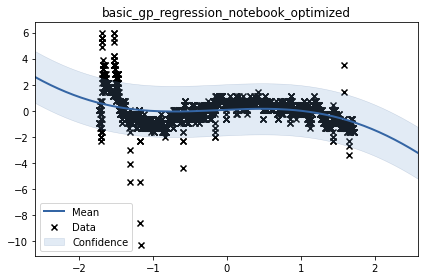

In [179]:
kernel = GPy.kern.RBF(input_dim=1, variance=5., lengthscale=4.)
#kernel = GPy.kern.PeriodicExponential(1)
model = GPy.models.GPRegression(trainTime, trainPulse, kernel)

display(model)

#fig = m.plot()
fig = model.plot(title='basic_gp_regression_notebook_optimized')

Optimization restart 1/2, f = 348.5452760865928
Optimization restart 2/2, f = 348.5452760863509


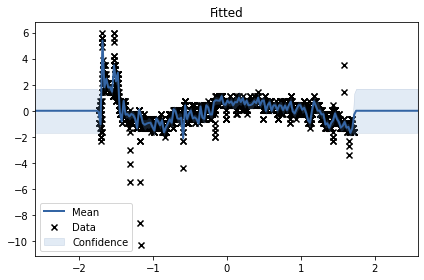

In [180]:
model.optimize(messages=True)
model.optimize_restarts(num_restarts = 2)

display(model)
#fig = m.plot()
fig = model.plot(title='Fitted')

In [181]:
twoFeatDF = train.loc[:,['Pulse', 'SpO2']]
twoFeatDF = twoFeatDF.reset_index(drop=True)
#yDF = train.loc[:,['RelativeTimeMilliseconds']]
yDF = train.loc[:,['Tidal Volume']]

print(yDF)
twoFeatDF

      Tidal Volume
5832           501
6358           667
6316           643
6270           621
1847           573
...            ...
4032           569
6513           702
1541           384
424            438
1010           468

[3582 rows x 1 columns]


Pulse   SpO2
0      55.0   98.0
1      55.0   99.0
2      55.0   99.0
3      56.0   99.0
4      51.0   99.0
...     ...    ...
3577   57.0   99.0
3578   52.0   99.0
3579   52.0   99.0
3580   60.0  100.0
3581   55.0  100.0

[3582 rows x 2 columns]

In [182]:
df_max_scaled = twoFeatDF.copy()

column = 'Pulse'
df_max_scaled[column] = df_max_scaled[column] /df_max_scaled[column].abs().max()

column = 'SpO2'
df_max_scaled[column] = df_max_scaled[column] /df_max_scaled[column].abs().max()

yDF= yDF /yDF.abs().max()

#X = df_max_scaled.values
#Y = yDF.values

print(X.shape)
#print(Y)
#print(X)

(3582, 3)


In [183]:
#Non normalized fit

# define kernel

kernel = GPy.kern.RBF(2, ARD=True)

threeDm = GPy.models.GPRegression(X,Y,kernel)

#fig = threeDm.plot(title='3 Feats')

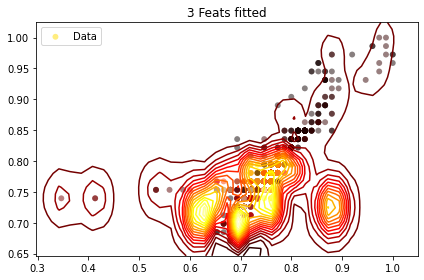

In [187]:
threeDm.optimize(messages=True,max_f_eval = 1000)

fig = threeDm.plot(title='3 Feats fitted', visible_dims = [0,1])

display(threeDm)

In [165]:
#predict test split

testFinal = test.loc[:,['Pulse', 'SpO2']]

testFF = testFinal.values

pred = threeDm.predict(testFF)

predQ = threeDm.predict_quantiles(testFF)

print(pred)
print("------------")
print(predQ)
print("------------")
print("mean of variance")
print(pred[1].mean())
print("------------")


    

    

(array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]]), array([[0.20540531],
       [0.20540531],
       [0.20540531],
       ...,
       [0.20540531],
       [0.20540531],
       [0.20540531]]))
------------
[array([[-0.88828826],
       [-0.88828826],
       [-0.88828826],
       ...,
       [-0.88828826],
       [-0.88828826],
       [-0.88828826]]), array([[0.88828826],
       [0.88828826],
       [0.88828826],
       ...,
       [0.88828826],
       [0.88828826],
       [0.88828826]])]
------------
mean of variance
0.20540531003731788
------------


In [158]:
print(threeDm)


Name : GP regression
Objective : -288.8704255166124
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |   0.15714784024863318  |      +ve      |        
  rbf.lengthscale          |  0.023750563192954155  |      +ve      |        
  Gaussian_noise.variance  |   0.04825746978868469  |      +ve      |        


Linear kernel


In [189]:
Lkernel = GPy.kern.Linear(2, ARD=True)

LinearDm = GPy.models.GPRegression(X,Y,Lkernel)


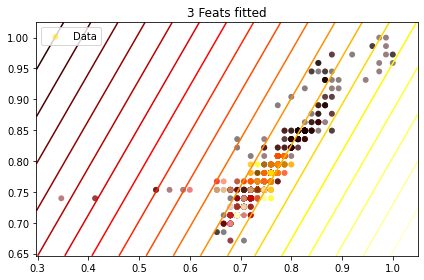

In [197]:
LinearDm.optimize(messages=True,max_f_eval = 1000)

fig = LinearDm.plot(title='3 Feats fitted', visible_dims = [0,1])

display(LinearDm)

Data to fit a four dimensional model


In [159]:
threeFeatDF = train.loc[:,['Pulse', 'HR', 'SpO2']]
threeFeatDF = threeFeatDF.reset_index(drop=True)
yDF = train.loc[:,['RelativeTimeMilliseconds']]

print(yDF)
threeFeatDF

      RelativeTimeMilliseconds
5003                   5003000
5072                   5072000
4280                   4280000
7084                   7084000
6648                   6648000
...                        ...
891                     891000
2008                   2008000
6665                   6665000
2251                   2251000
6629                   6629000

[3582 rows x 1 columns]


Pulse    HR   SpO2
0      57.0  57.0   97.0
1      54.0  54.0   97.0
2      59.0  58.0   99.0
3      52.0  52.0   99.0
4      55.0  55.0   99.0
...     ...   ...    ...
3577   55.0  55.0  100.0
3578   54.0  54.0   99.0
3579   54.0  55.0   99.0
3580   54.0  54.0   99.0
3581   56.0  55.0   99.0

[3582 rows x 3 columns]

In [160]:
df_max_scaled = threeFeatDF.copy()

column = 'Pulse'
df_max_scaled[column] = df_max_scaled[column] /df_max_scaled[column].abs().max()

column = 'HR'
df_max_scaled[column] = df_max_scaled[column] /df_max_scaled[column].abs().max()

column = 'SpO2'
df_max_scaled[column] = df_max_scaled[column] /df_max_scaled[column].abs().max()

yDF= yDF /yDF.abs().max()

X = df_max_scaled.values
Y = yDF.values

print(X.shape)
#print(X)

print(df_max_scaled)


(3582, 3)
         Pulse        HR  SpO2
0     0.760000  0.780822  0.97
1     0.720000  0.739726  0.97
2     0.786667  0.794521  0.99
3     0.693333  0.712329  0.99
4     0.733333  0.753425  0.99
...        ...       ...   ...
3577  0.733333  0.753425  1.00
3578  0.720000  0.739726  0.99
3579  0.720000  0.753425  0.99
3580  0.720000  0.739726  0.99
3581  0.746667  0.753425  0.99

[3582 rows x 3 columns]


In [161]:
kernel = GPy.kern.RBF(3, ARD=True)

fourDm = GPy.models.GPRegression(X,Y,kernel)

#fig = fourDm.plot(title='4 Feats', visible_dims = )

In [162]:
fourDm.optimize(messages=True,max_f_eval = 1000)

display(fourDm)

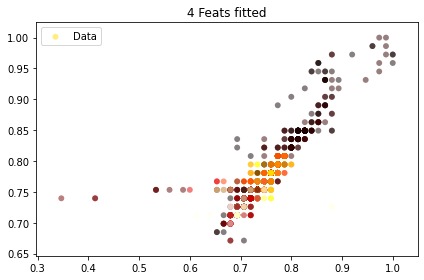

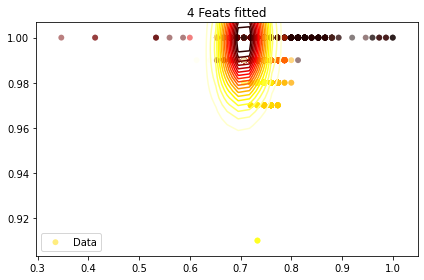

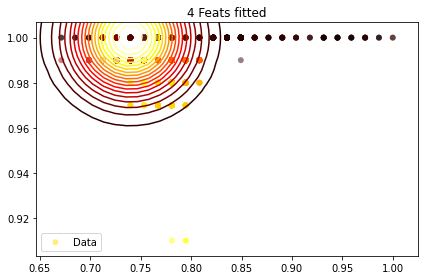

In [163]:
fig = fourDm.plot(title='4 Feats fitted', visible_dims = [0,1])
fig = fourDm.plot(title='4 Feats fitted', visible_dims = [0,2])
fig = fourDm.plot(title='4 Feats fitted', visible_dims = [1,2])

In [198]:
testFinal = test.loc[:,['Pulse', 'HR', 'SpO2']]

testFF = testFinal.values

fourDpred = fourDm.predict(testFF)



In [199]:
print(fourDpred)
print("------------")
print("mean of variance")
print(fourDpred[1].mean())
print("------------")

(array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]]), array([[0.17322453],
       [0.17322453],
       [0.17322453],
       ...,
       [0.17322453],
       [0.17322453],
       [0.17322453]]))
------------
mean of variance
0.173224525786698
------------


In [200]:
print(fourDm)


Name : GP regression
Objective : -349.32548881759385
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |   0.12744232088903315  |      +ve      |        
  rbf.lengthscale          |                  (3,)  |      +ve      |        
  Gaussian_noise.variance  |  0.045782204897664866  |      +ve      |        
